In [3]:
import pandas as pd
import numpy as np
import pandahouse
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

sns.set(rc={'figure.figsize':(15,8)})


connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20220720'
}



def extract_data():
        connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20220720'}
        
        query = """
        select *, dense_rank() over(partition by d  order by t_period) rn
        from
        (select toDayOfWeek(time) day_of_week, toDate(time) d, toStartOfFifteenMinutes(time) t_period, 
                os, count(distinct user_id) f_users, 
                countIf(action, action = 'view') views, 
                countIf(action, action = 'like') likes,
                likes/views ctr
        from simulator_20220720.feed_actions 
        where toDate(time) between yesterday()-60 and yesterday()
        group by t_period, d, day_of_week, os ) f
        join (
                select toDayOfWeek(time) day_of_week, toDate(time) d,  toStartOfFifteenMinutes(time) t_period, 
                os, count(distinct user_id) m_users,
                count(reciever_id) messages
                from simulator_20220720.message_actions
                where toDate(time) between yesterday()-60 and yesterday()
                group by t_period, d, day_of_week, os
            ) m using (day_of_week, d, t_period, os)
        order by t_period, day_of_week, os
        
            
                """
        df = pandahouse.read_clickhouse(query = query, connection=connection)
        return df

    
# вместо 15-минутных отрезков вида ('00:00:15') будем использовать порядковый номер 15-минутки. 
# То есть, '00:00:00' - это 1, а '23:45:00' - это 96. Это сократит записи по осям.
# Выделим вчера в отдельную переменную , зададим также разницу в днях между вчера и всеми остальными днями
df = extract_data()
df['just_t'] = df['t_period'].dt.time    
yesterday = pd.to_datetime(df['d'].max())
df['dif_in_days'] =  (yesterday -  df['d']).dt.days

# и поменяем тип
df['day_of_week'] = df['day_of_week'].astype('int8')
df['f_users'] = df['f_users'].astype('int64')
df['m_users'] = df['m_users'].astype('int64')
df['views'] = df['views'].astype('int64')
df['likes'] = df['likes'].astype('int64')
df['messages'] = df['messages'].astype('int64')
df['rn'] = df['rn'].astype('int64')

# Создадим отдельный df с записями за месяц и посмотрим несколько графиков
df_month = df[df['dif_in_days'] <= 30 ]
#df_month.head()

# df для недели
df_week = df[df['dif_in_days'] < 7]
# df_week.head()

df.head()

day_of_week          d            t_period       os  f_users  views  likes  \
0            5 2022-07-08 2022-07-08 00:00:00  Android      242   3592    804   
1            5 2022-07-08 2022-07-08 00:00:00      iOS      149   2185    431   
2            5 2022-07-08 2022-07-08 00:15:00  Android      246   3724    845   
3            5 2022-07-08 2022-07-08 00:15:00      iOS      144   2164    501   
4            5 2022-07-08 2022-07-08 00:30:00  Android      237   3483    746   

        ctr  m_users  messages  rn    just_t  dif_in_days  
0  0.223831       42        46   1  00:00:00           47  
1  0.197254       35        37   1  00:00:00           47  
2  0.226907       40        50   2  00:15:00           47  
3  0.231516       26        29   2  00:15:00           47  
4  0.214183       40        50   3  00:30:00           47

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9216 entries, 0 to 9215
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   day_of_week  9216 non-null   int8          
 1   d            9216 non-null   datetime64[ns]
 2   t_period     9216 non-null   datetime64[ns]
 3   os           9216 non-null   object        
 4   f_users      9216 non-null   int64         
 5   views        9216 non-null   int64         
 6   likes        9216 non-null   int64         
 7   ctr          9216 non-null   float64       
 8   m_users      9216 non-null   int64         
 9   messages     9216 non-null   int64         
 10  rn           9216 non-null   int64         
 11  just_t       9216 non-null   object        
 12  dif_in_days  9216 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(7), int8(1), object(2)
memory usage: 873.1+ KB


МЕСЯЦ

Text(0.5, 1.0, 'Views for month by 15-min and os')

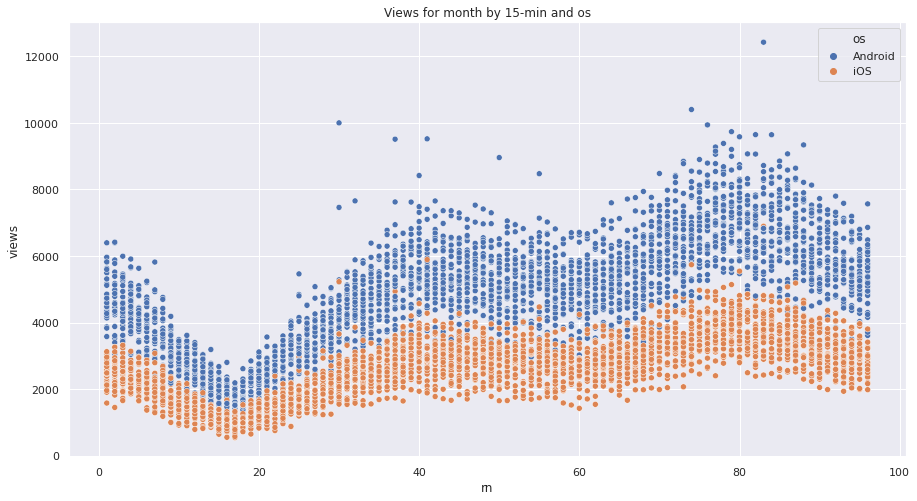

In [5]:
sns.scatterplot(data = df_month,\
                x = 'rn', y = 'views', hue = 'os')
plt.title('Views for month by 15-min and os')

Text(0.5, 1.0, 'Likes for month by 15-min and os')

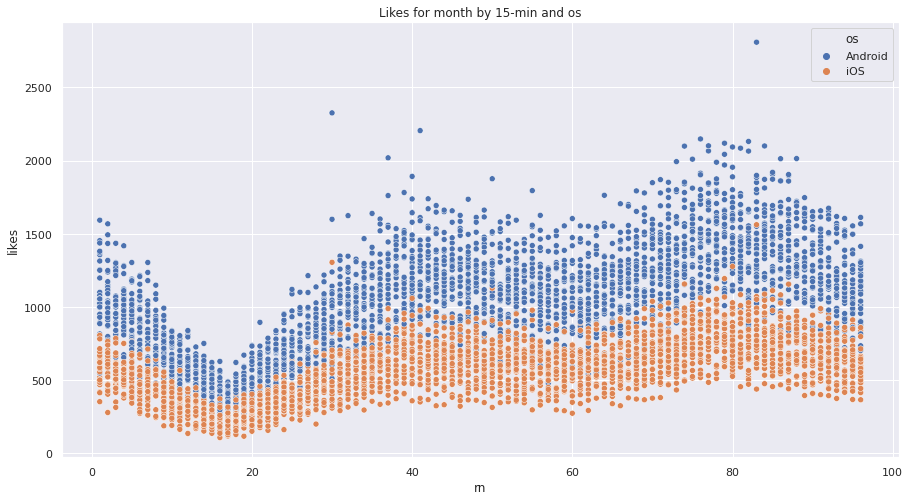

In [6]:
sns.scatterplot(data = df_month,\
                x = 'rn', y = 'likes', hue = 'os')
plt.title('Likes for month by 15-min and os')

Text(0.5, 1.0, 'DAU in feed for month by 15-min and os')

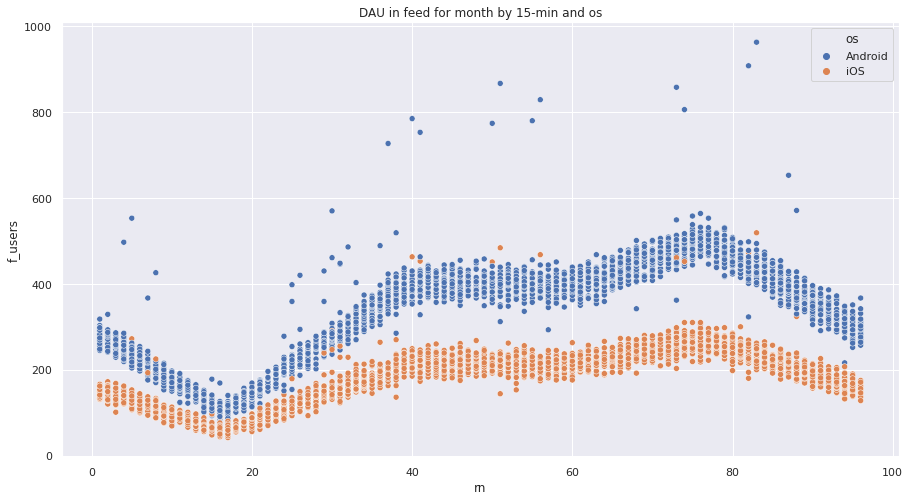

In [7]:
sns.scatterplot(data = df_month,\
                x = 'rn', y = 'f_users', hue = 'os')
plt.title('DAU in feed for month by 15-min and os')

Text(0.5, 1.0, 'ctr in feed for month by 15-min and os')

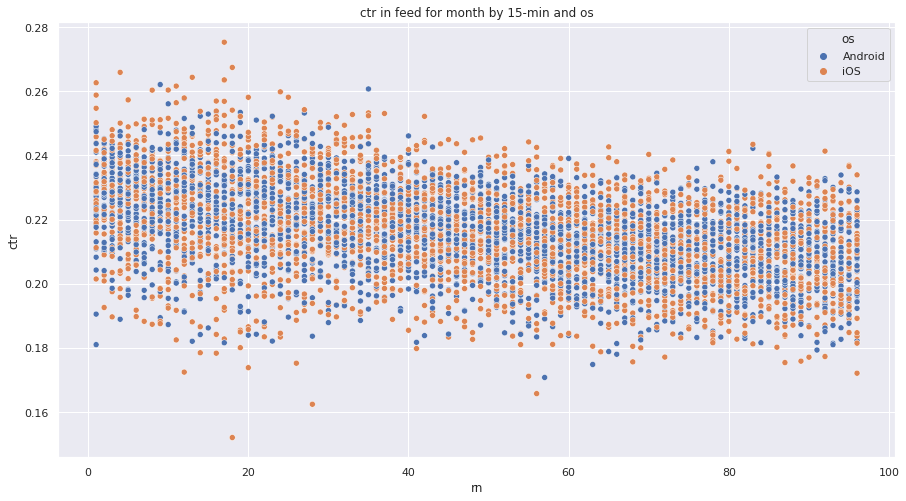

In [8]:
sns.scatterplot(data = df_month,\
                x = 'rn', y = 'ctr', hue = 'os')
plt.title('ctr in feed for month by 15-min and os')

Text(0.5, 1.0, 'DAU for messenger for month by 15-min and os')

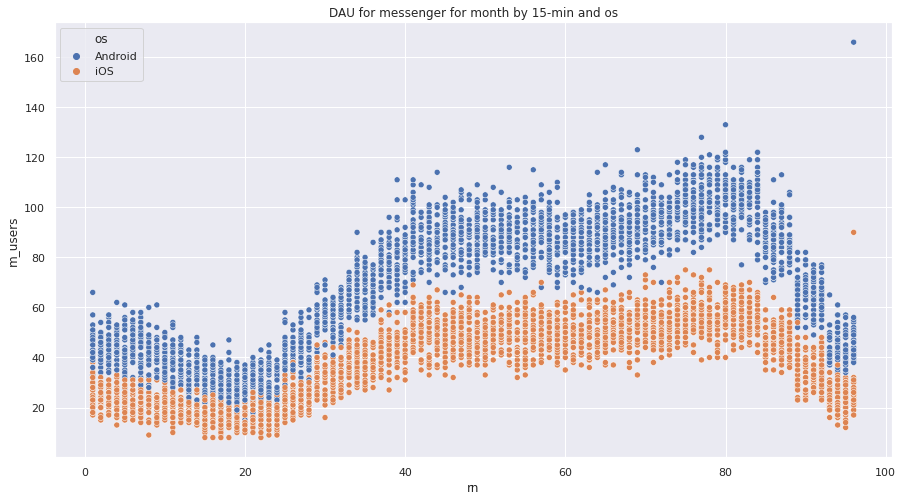

In [9]:
sns.scatterplot(data = df_month,\
                x = 'rn', y = 'm_users', hue = 'os')
plt.title('DAU for messenger for month by 15-min and os')

Text(0.5, 1.0, 'Messages for month by 15-min and os')

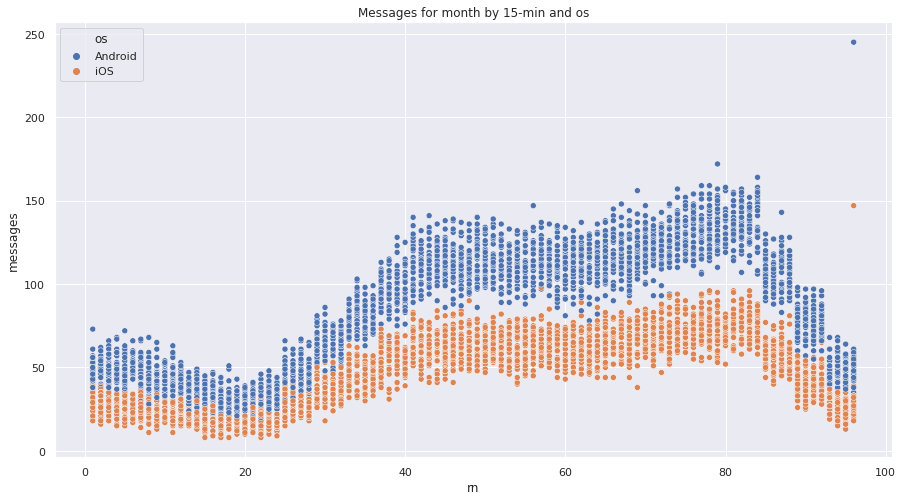

In [10]:
sns.scatterplot(data = df_month,\
                x = 'rn', y = 'messages', hue = 'os')
plt.title('Messages for month by 15-min and os')

In [11]:
# итак, что мы видим:
# разделение по ос является хорошим решением - у этих групп точно разные средние и точки зачастую не пересекаются вообще.
# При этом на всех графиках, не считая ctr, выбросы у андроидов и ios-ов очень часто повторяют друг друга.
# Лайки и просмотры очень похожи по поведению.
# интересные группы выбросов в сообщениях в первой половине каких-то(скорее всего одного) дней.
# странно, но у ios-ов  дисперсия ctr выше. 

<AxesSubplot:xlabel='f_users', ylabel='Count'>

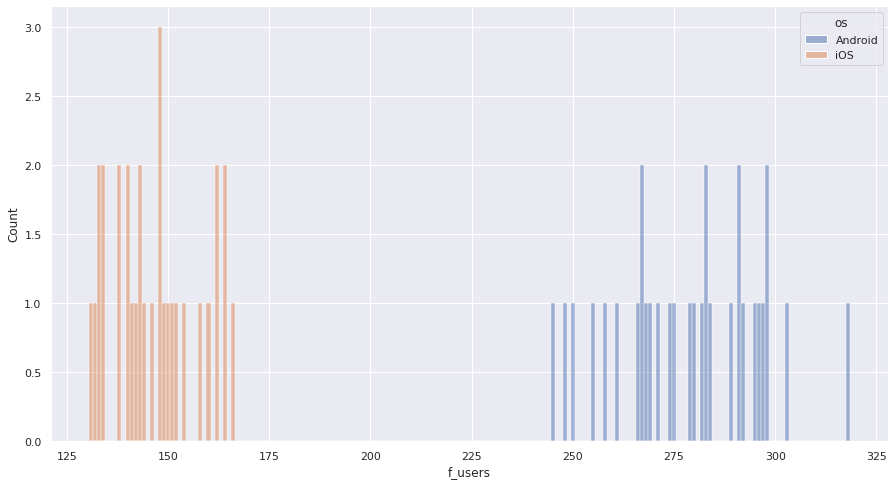

In [12]:
# первым из статистических способов определения алёрта рассмотрим 3 сигмы. Нам нужно что-то похожее на норм.распределение
# У нас есть 30 дней - 30 записей каждой 15-минутки. Возьмём первую. Не очень похоже на норм.распр.
sns.histplot(data = df_month[df_month['rn'] == 1], x = 'f_users', discrete = True, hue = 'os')

/tmp/ipykernel_143/4171086688.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data = df_month[(df_month['rn'] == 1) &  \


<AxesSubplot:xlabel='f_users', ylabel='Count'>

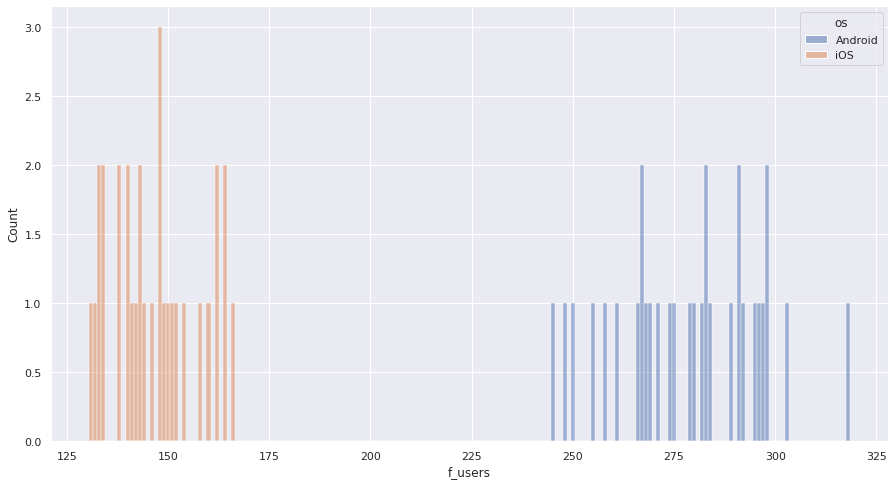

In [13]:
# а если убрать 2 самых явных выброса? Всё равно не сильно похоже
sns.histplot(data = df_month[(df_month['rn'] == 1) &  \
                            (df['f_users'] < 350)], x = 'f_users', discrete = True, hue = 'os')

In [14]:
# Посмотрим на СКО и среднее. Что интересно: на графике видно, что для обеих групп все данные кроме двух
# выбросов лежат в пределах 1 сигмы. 
df_month[df_month['rn'] == 1].groupby('os')['f_users'].describe()

count        mean        std    min    25%    50%    75%    max
os                                                                      
Android   31.0  278.483871  17.687794  245.0  267.0  280.0  291.5  318.0
iOS       31.0  146.709677  10.577314  131.0  139.0  146.0  153.0  166.0

<AxesSubplot:xlabel='f_users', ylabel='Count'>

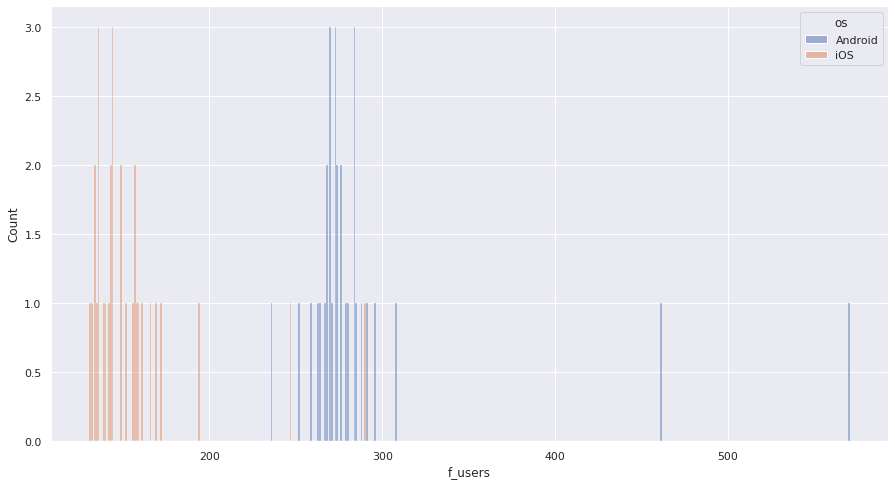

In [15]:
# попробуем ещё пару произвольных 15-минуток в разных метриках
sns.histplot(data = df_month[df_month['rn'] == 30], x = 'f_users', discrete = True, hue = 'os')

<AxesSubplot:xlabel='messages', ylabel='Count'>

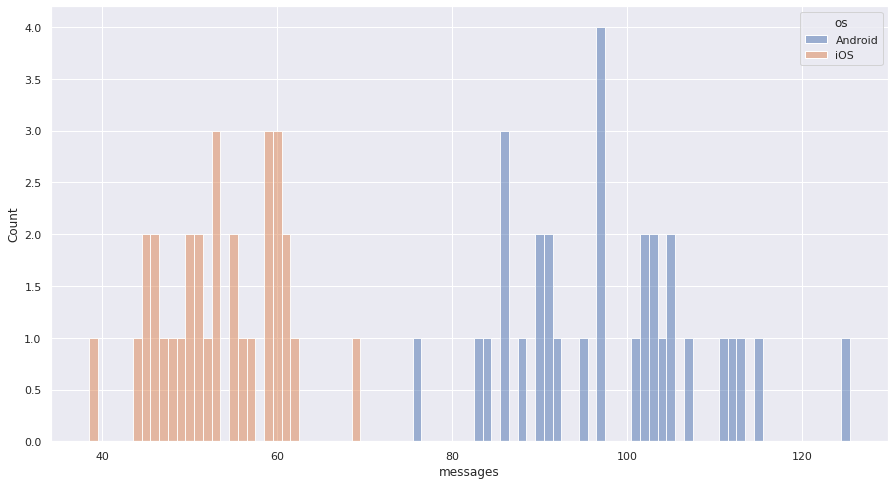

In [16]:
sns.histplot(data = df_month[df_month['rn'] == 40], x = 'messages', discrete = True, hue = 'os')

<AxesSubplot:xlabel='m_users', ylabel='Count'>

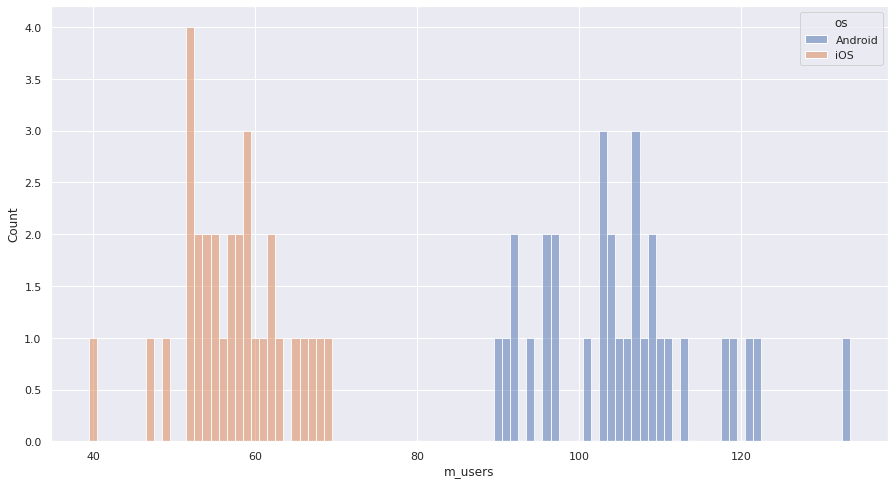

In [17]:
sns.histplot(data = df_month[df_month['rn'] == 80], x = 'm_users', discrete = True, hue = 'os')

<AxesSubplot:xlabel='ctr', ylabel='Count'>

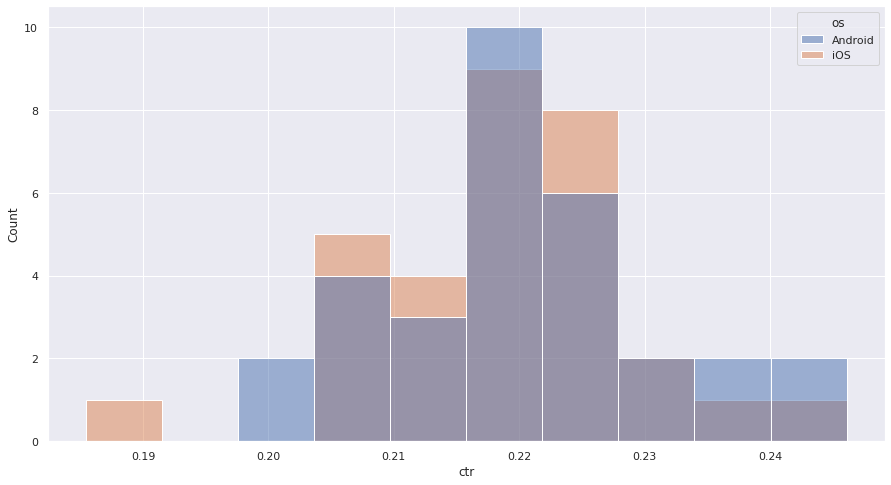

In [18]:
sns.histplot(data = df_month[df_month['rn'] == 40], x = 'ctr', hue = 'os')

<AxesSubplot:xlabel='f_users', ylabel='Count'>

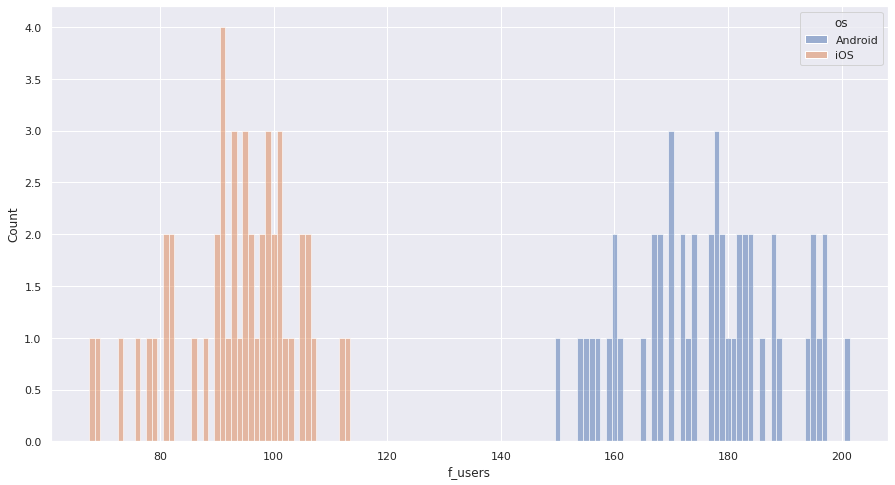

In [19]:
# а если взять два месяца?
# И всё равно нет. Нормальности нет.
sns.histplot(data = df[df['rn'] == 10], x = 'f_users', hue = 'os', discrete = True)

In [20]:
df[df['rn'] == 10].groupby('os')['f_users'].describe()

count        mean        std    min     25%    50%     75%    max
os                                                                        
Android   48.0  176.104167  12.912537  150.0  167.75  177.5  184.00  201.0
iOS       48.0   93.354167  10.521487   68.0   89.50   95.0  100.25  113.0

In [21]:
# посмотрим на доверительный интервал 0.9 t-распределения для какой-нибудь 15-минутки
df_month[df_month['rn'] == 50].groupby('os')['f_users'].describe()

count        mean        std    min    25%    50%    75%    max
os                                                                      
Android   31.0  409.548387  70.109362  356.0  387.0  397.0  412.0  774.0
iOS       31.0  220.709677  44.188380  192.0  207.0  214.0  219.5  451.0

In [22]:
# андроид
m = 406.774194
s = 221.032258
dof = 30-1 
confidence = 0.9

t_crit = np.abs(stats.t.ppf((1-confidence)/2,dof))

(m-s*t_crit/np.sqrt(30), m+s*t_crit/np.sqrt(30))

(338.2062889251789, 475.34209907482114)

<AxesSubplot:xlabel='f_users', ylabel='Count'>

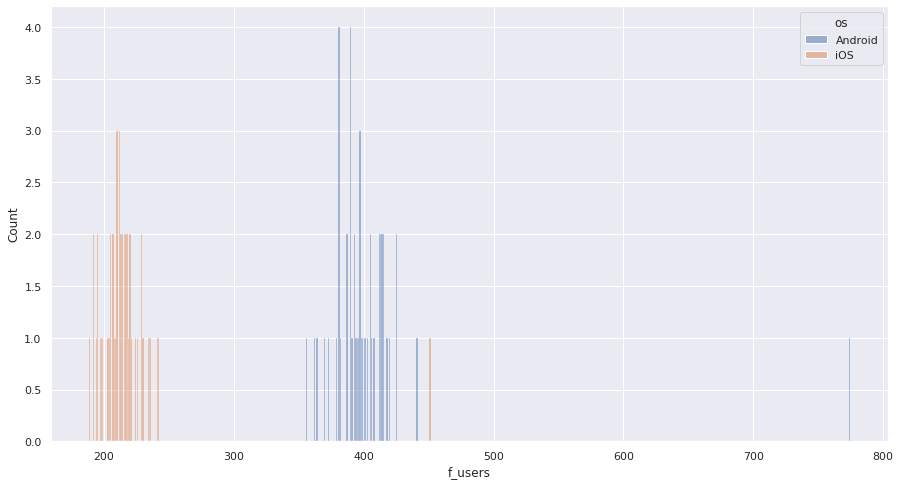

In [23]:
sns.histplot(data = df[df['rn'] == 50], x = 'f_users', hue = 'os', discrete = True)

In [24]:
# Вывод: 3 сигмы кажутся не лучшим решением. Представим, что наше значение сегодня будет отклонятся от среднего месяца
# на  2 - 2.5 сигмы. Правило его примет. Но простого взгяда на графики достаточно будет, чтобы счеть значение аномалией.
# На некоторых 15-минутках и метриках оно вполне будет работать. Но не на всех.

# Можно было бы бутстрапировать каждую 15-минутку. Но тогда у нас будет 96 * 2(ос) * 6 (кол-во метрик) 
# бутстрап-распределений за день. Как-то чересчур.

# Тогда будем пробовать межквартильный размах.

In [25]:
# В нескольких следующих ниже клетках вплоть до вывода с помощью графиков рассматривается,
# подходит ли нам межквартильный казмах 

In [26]:
df_month[df_month['rn'] == 1].groupby('os')['f_users'].describe()

count        mean        std    min    25%    50%    75%    max
os                                                                      
Android   31.0  278.483871  17.687794  245.0  267.0  280.0  291.5  318.0
iOS       31.0  146.709677  10.577314  131.0  139.0  146.0  153.0  166.0

In [27]:
rn = 1
metric = 'f_users'
lq = df_month[(df_month['rn'] == rn) & (df_month['os'] == 'iOS')][metric].quantile(0.25)
rq = df_month[(df_month['rn'] == rn) & (df_month['os'] == 'iOS')][metric].quantile(0.75)
iqr = rq - lq 
a = 1.5
mask = (df_month[metric] < lq - a * iqr) | (df_month[metric] > rq + a * iqr)
df_month[(df_month['rn'] == rn) & (df_month['os'] == 'iOS') & (mask)]

Empty DataFrame
Columns: [day_of_week, d, t_period, os, f_users, views, likes, ctr, m_users, messages, rn, just_t, dif_in_days]
Index: []

In [28]:
df_month[df_month['rn'] == 50].groupby('os')['f_users'].describe()

count        mean        std    min    25%    50%    75%    max
os                                                                      
Android   31.0  409.548387  70.109362  356.0  387.0  397.0  412.0  774.0
iOS       31.0  220.709677  44.188380  192.0  207.0  214.0  219.5  451.0

In [29]:
rn = 50
metric = 'f_users'
lq = df_month[(df_month['rn'] == rn) & (df_month['os'] == 'iOS')][metric].quantile(0.25)
rq = df_month[(df_month['rn'] == rn) & (df_month['os'] == 'iOS')][metric].quantile(0.75)
iqr = rq - lq 
a = 1.5
mask = (df_month[metric] < lq - a * iqr) | (df_month[metric] > rq + a * iqr)
df_month[(df_month['rn'] == rn) & (df_month['os'] == 'iOS') & (mask)]

day_of_week          d            t_period   os  f_users  views  likes  \
6243            2 2022-08-09 2022-08-09 12:15:00  iOS      451   5459   1129   

           ctr  m_users  messages  rn    just_t  dif_in_days  
6243  0.206814       54        68  50  12:15:00           15

In [30]:
rn = 30
metric = 'm_users'
lq = df_month[(df_month['rn'] == rn) & (df_month['os'] == 'iOS')][metric].quantile(0.25)
rq = df_month[(df_month['rn'] == rn) & (df_month['os'] == 'iOS')][metric].quantile(0.75)
iqr = rq - lq 
a = 1.5
mask = (df_month[metric] < lq - a * iqr) | (df_month[metric] > rq + a * iqr)
df_month[(df_month['rn'] == rn) & (df_month['os'] == 'iOS') & (mask)]

day_of_week          d            t_period   os  f_users  views  likes  \
5243            4 2022-08-04 2022-08-04 07:15:00  iOS      143   1598    309   
6011            1 2022-08-08 2022-08-08 07:15:00  iOS      143   2243    454   

           ctr  m_users  messages  rn    just_t  dif_in_days  
5243  0.193367       46        53  30  07:15:00           20  
6011  0.202407       16        18  30  07:15:00           16

<AxesSubplot:xlabel='m_users'>

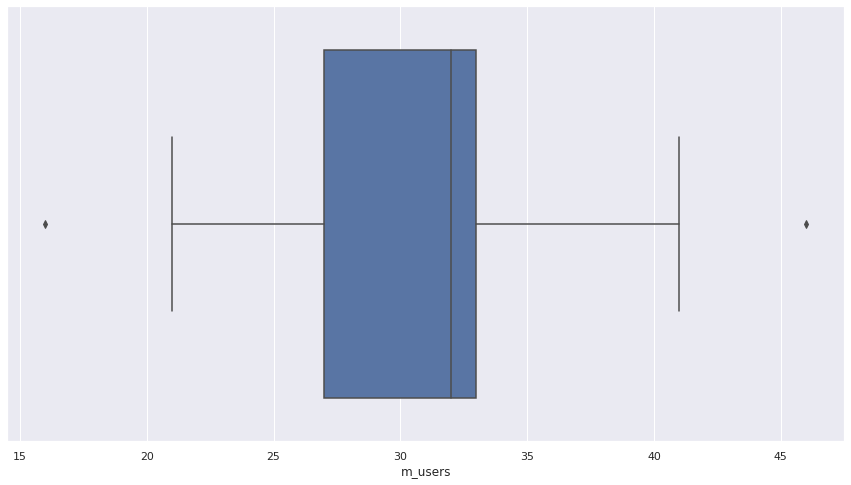

In [31]:
sns.boxplot(data = df_month[(df_month['rn'] == 30) & (df_month['os'] == 'iOS')], x = 'm_users')

Text(0.5, 1.0, 'ctr in feed for month by 15-min and os')

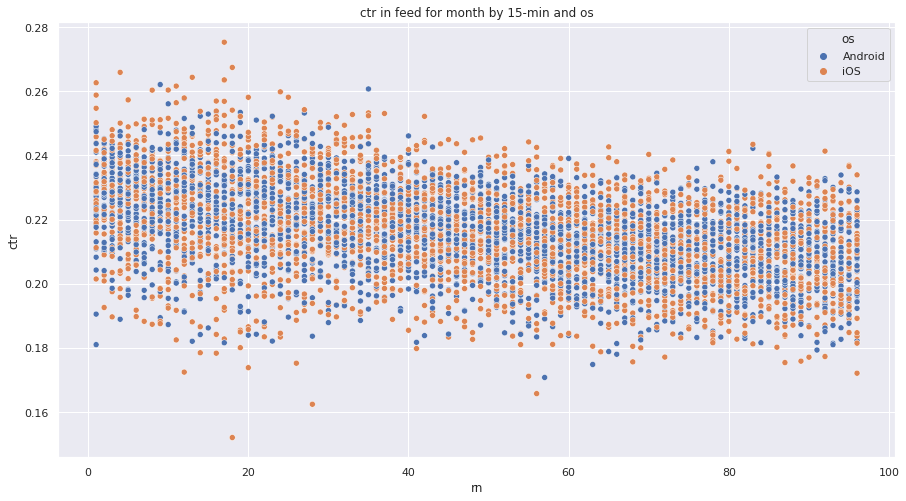

In [32]:
sns.scatterplot(data = df_month,\
                x = 'rn', y = 'ctr', hue = 'os')
plt.title('ctr in feed for month by 15-min and os')

In [33]:
rn = 80
metric = 'ctr'
lq = df_month[(df_month['rn'] == rn) & (df_month['os'] == 'iOS')][metric].quantile(0.25)
rq = df_month[(df_month['rn'] == rn) & (df_month['os'] == 'iOS')][metric].quantile(0.75)
iqr = rq - lq 
a = 1.5
mask = (df_month[metric] < lq - a * iqr) | (df_month[metric] > rq + a * iqr)
df_month[(df_month['rn'] == rn) & (df_month['os'] == 'iOS') & (mask)]

Empty DataFrame
Columns: [day_of_week, d, t_period, os, f_users, views, likes, ctr, m_users, messages, rn, just_t, dif_in_days]
Index: []

In [34]:
rn = 16
metric = 'ctr'
lq = df_month[(df_month['rn'] == rn) & (df_month['os'] == 'iOS')][metric].quantile(0.25)
rq = df_month[(df_month['rn'] == rn) & (df_month['os'] == 'iOS')][metric].quantile(0.75)
iqr = rq - lq 
a = 1.5
mask = (df_month[metric] < lq - a * iqr) | (df_month[metric] > rq + a * iqr)
df_month[(df_month['rn'] == rn) & (df_month['os'] == 'iOS') & (mask)]

Empty DataFrame
Columns: [day_of_week, d, t_period, os, f_users, views, likes, ctr, m_users, messages, rn, just_t, dif_in_days]
Index: []

<AxesSubplot:xlabel='rn', ylabel='ctr'>

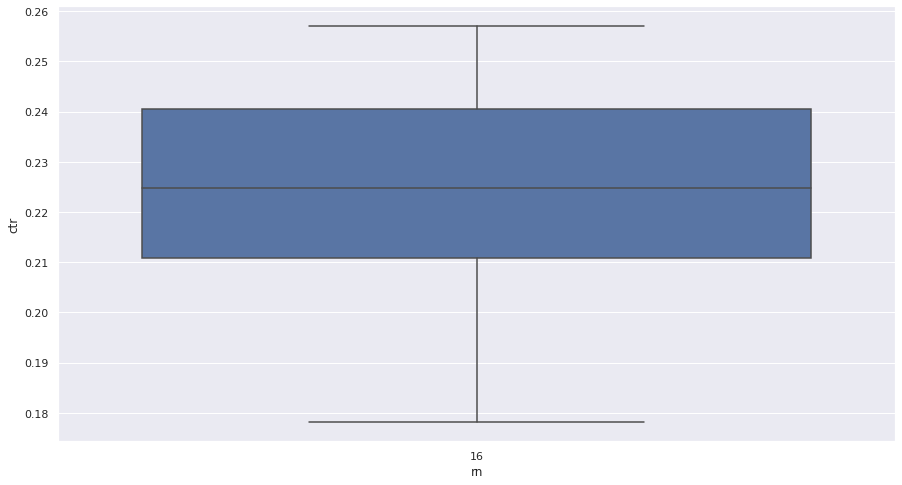

In [35]:
sns.boxplot(data = df_month[(df_month['rn'] == 16) & (df_month['os'] == 'iOS')], x = 'rn', y = 'ctr')

In [36]:
rn = 18
metric = 'ctr'
lq = df_month[(df_month['rn'] == rn) & (df_month['os'] == 'iOS')][metric].quantile(0.25)
rq = df_month[(df_month['rn'] == rn) & (df_month['os'] == 'iOS')][metric].quantile(0.75)
iqr = rq - lq 
a = 1.5
mask = (df_month[metric] < lq - a * iqr) | (df_month[metric] > rq + a * iqr)
df_month[(df_month['rn'] == rn) & (df_month['os'] == 'iOS') & (mask)]

day_of_week          d            t_period   os  f_users  views  likes  \
5219            4 2022-08-04 2022-08-04 04:15:00  iOS       70    849    129   
7715            3 2022-08-17 2022-08-17 04:15:00  iOS       72   1529    409   

           ctr  m_users  messages  rn    just_t  dif_in_days  
5219  0.151943       13        13  18  04:15:00           20  
7715  0.267495       20        22  18  04:15:00            7

<AxesSubplot:xlabel='rn', ylabel='ctr'>

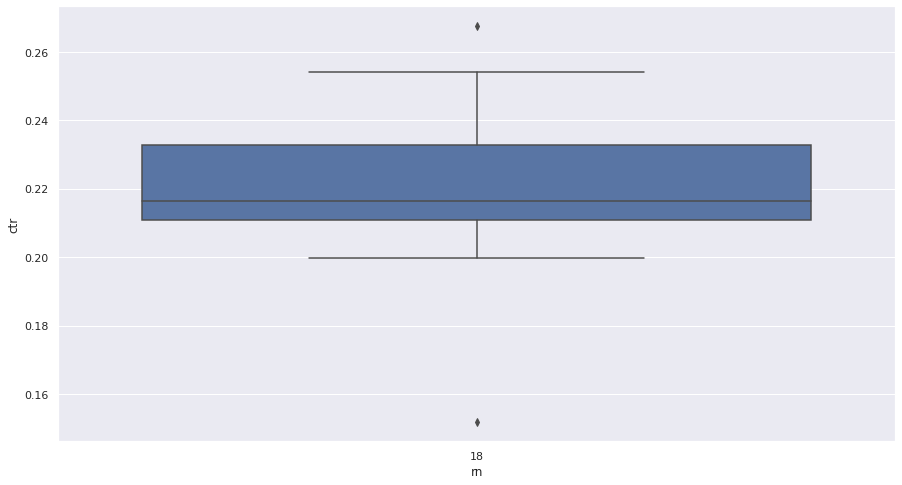

In [37]:
sns.boxplot(data = df_month[(df_month['rn'] == 18) & (df_month['os'] == 'iOS')], x = 'rn', y = 'ctr')

Text(0.5, 1.0, 'Messages for month by 15-min and os')

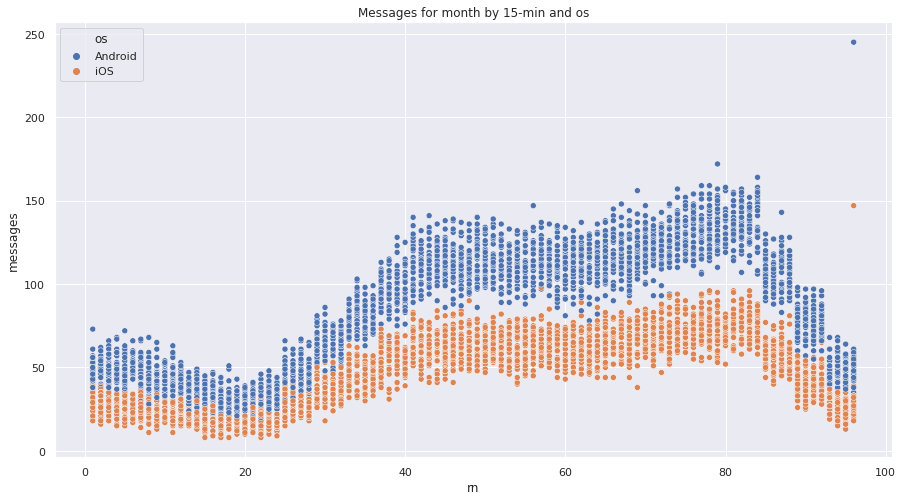

In [38]:
sns.scatterplot(data = df_month,\
                x = 'rn', y = 'messages', hue = 'os')
plt.title('Messages for month by 15-min and os')

In [39]:
rn = 18
metric = 'messages'
lq = df_month[(df_month['rn'] == rn) & (df_month['os'] == 'iOS')][metric].quantile(0.25)
rq = df_month[(df_month['rn'] == rn) & (df_month['os'] == 'iOS')][metric].quantile(0.75)
iqr = rq - lq 
a = 1.5
mask = (df_month[metric] < lq - a * iqr) | (df_month[metric] > rq + a * iqr)
df_month[(df_month['rn'] == rn) & (df_month['os'] == 'iOS') & (mask)]

Empty DataFrame
Columns: [day_of_week, d, t_period, os, f_users, views, likes, ctr, m_users, messages, rn, just_t, dif_in_days]
Index: []

In [40]:
rn = 60
metric = 'messages'
lq = df_month[(df_month['rn'] == rn) & (df_month['os'] == 'iOS')][metric].quantile(0.25)
rq = df_month[(df_month['rn'] == rn) & (df_month['os'] == 'iOS')][metric].quantile(0.75)
iqr = rq - lq 
a = 1.5
mask = (df_month[metric] < lq - a * iqr) | (df_month[metric] > rq + a * iqr)
df_month[(df_month['rn'] == rn) & (df_month['os'] == 'iOS') & (mask)]

Empty DataFrame
Columns: [day_of_week, d, t_period, os, f_users, views, likes, ctr, m_users, messages, rn, just_t, dif_in_days]
Index: []

In [41]:
# Вывод: межквартильный размах куда лучше подходит нам для определения аномалий, чем 3*сигма
# В большинстве рассмотренных выше случаях iqr не выходил за пределы 1.5*сигма, что для наших данных,
# в большинстве которых есть всего один-два выброса, сильно искажающих картину, 
# и нет плавного снижения в хвостах, подходит больше.

In [42]:
df.columns

Index(['day_of_week', 'd', 't_period', 'os', 'f_users', 'views', 'likes',
       'ctr', 'm_users', 'messages', 'rn', 'just_t', 'dif_in_days'],
      dtype='object')

НЕДЕЛЯ

In [43]:

# Раз уж 3*сигма не подошло нам для месяца, то точно не подойдёт для недели. Сразу будем смотреть iqr

Text(0.5, 1.0, 'Messages for week by 15-min and os')

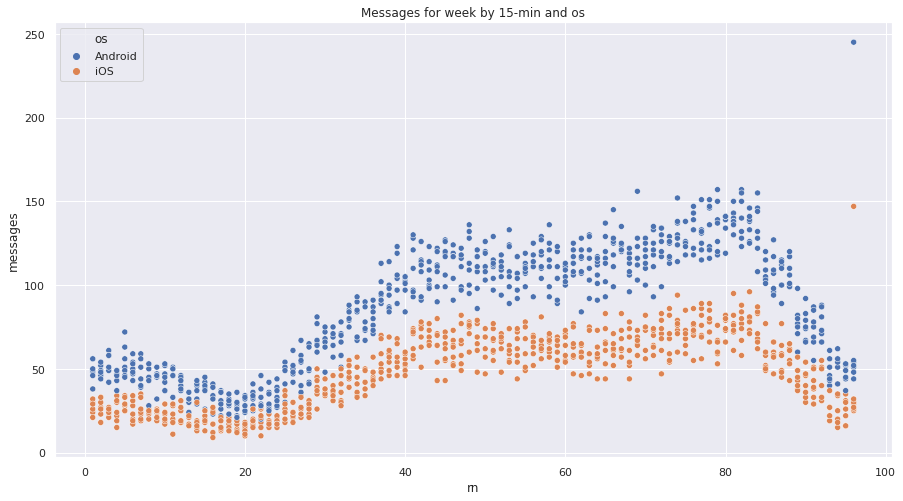

In [44]:
sns.scatterplot(data = df_week,\
                x = 'rn', y = 'messages', hue = 'os')
plt.title('Messages for week by 15-min and os')

Text(0.5, 1.0, 'DAU in mess for week by 15-min and os')

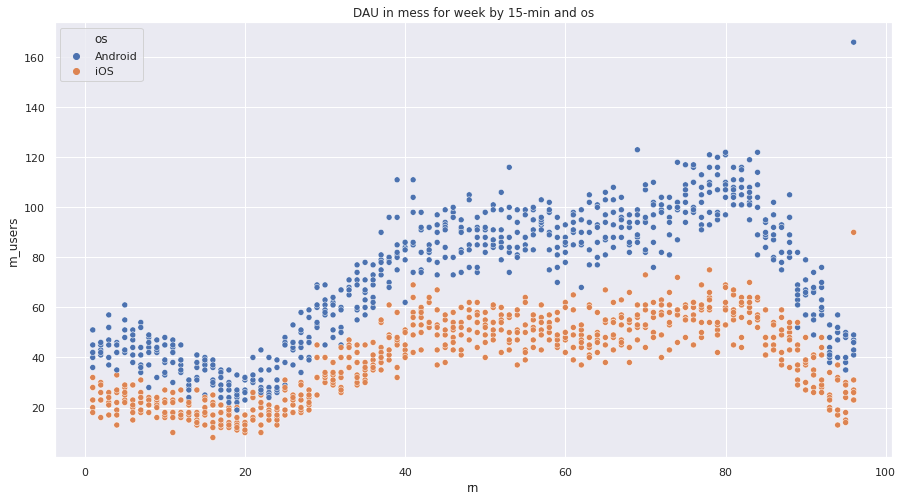

In [45]:
sns.scatterplot(data = df_week,\
                x = 'rn', y = 'm_users', hue = 'os')
plt.title('DAU in mess for week by 15-min and os')

Text(0.5, 1.0, 'DAU in feed for week by 15-min and os')

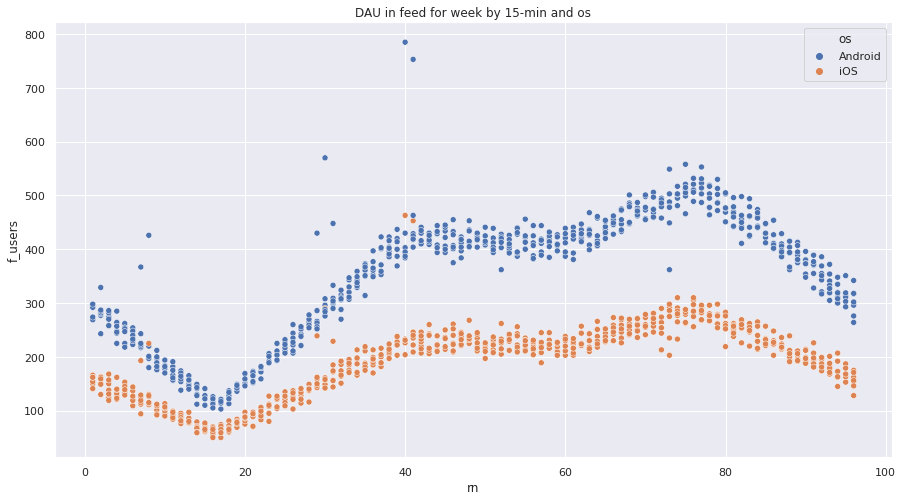

In [46]:
sns.scatterplot(data = df_week,\
                x = 'rn', y = 'f_users', hue = 'os')
plt.title('DAU in feed for week by 15-min and os')

Text(0.5, 1.0, 'Views for week by 15-min and os')

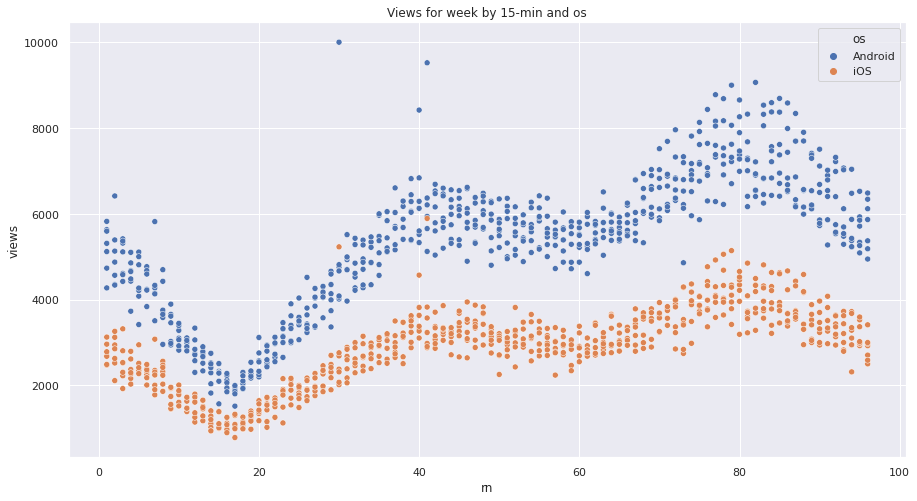

In [47]:
sns.scatterplot(data = df_week,\
                x = 'rn', y = 'views', hue = 'os')
plt.title('Views for week by 15-min and os')

Text(0.5, 1.0, 'Likes for week by 15-min and os')

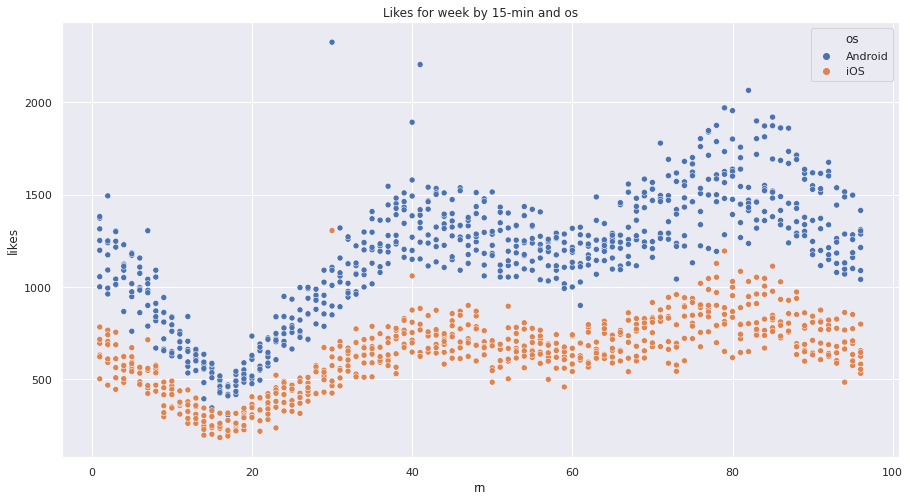

In [48]:
sns.scatterplot(data = df_week,\
                x = 'rn', y = 'likes', hue = 'os')
plt.title('Likes for week by 15-min and os')

Text(0.5, 1.0, 'CTR for week by 15-min and os')

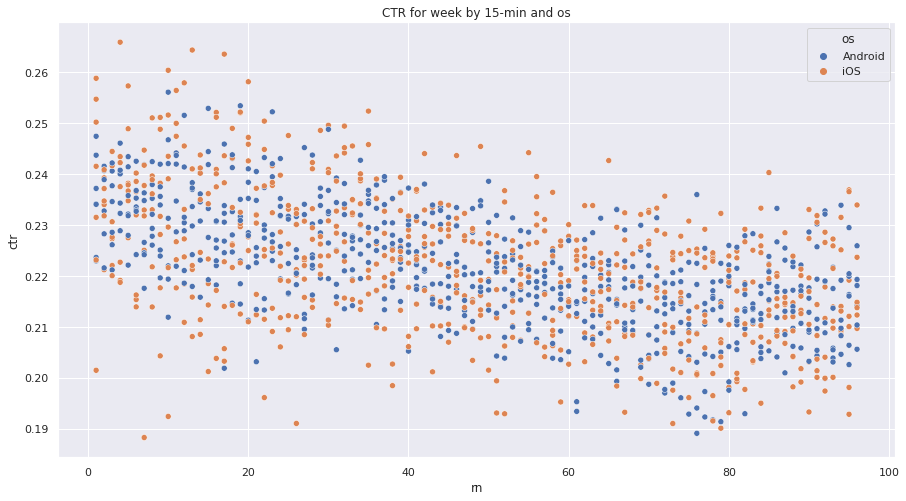

In [49]:
sns.scatterplot(data = df_week,\
                x = 'rn', y = 'ctr', hue = 'os')
plt.title('CTR for week by 15-min and os')

In [50]:
# Некоторые выводы по прошлой неделе(03.08-10.08):
# выбросы по ios и android, как и в месяце, часто коррелируют.
# лайки и просмотры так же похожи поведением
# в мессенджере не было никаких сильных выбросов

In [51]:
rn = 50
metric = 'f_users'
lq = df_week[(df_week['rn'] == rn) & (df_week['os'] == 'iOS')][metric].quantile(0.25)
rq = df_week[(df_week['rn'] == rn) & (df_week['os'] == 'iOS')][metric].quantile(0.75)
iqr = rq - lq 
a = 2
mask = (df_week[metric] < lq - a * iqr) | (df_week[metric] > rq + a * iqr)
df_week[(df_week['rn'] == rn) & (df_week['os'] == 'iOS') & (mask)]

Empty DataFrame
Columns: [day_of_week, d, t_period, os, f_users, views, likes, ctr, m_users, messages, rn, just_t, dif_in_days]
Index: []

In [52]:
rn = 30
metric = 'f_users'
lq = df_week[(df_week['rn'] == rn) & (df_week['os'] == 'iOS')][metric].quantile(0.25)
rq = df_week[(df_week['rn'] == rn) & (df_week['os'] == 'iOS')][metric].quantile(0.75)
iqr = rq - lq 
a = 1.5
mask = (df_week[metric] < lq - a * iqr) | (df_week[metric] > rq + a * iqr)
df_week[(df_week['rn'] == rn) & (df_week['os'] == 'iOS') & (mask)]

day_of_week          d            t_period   os  f_users  views  likes  \
8507            7 2022-08-21 2022-08-21 07:15:00  iOS      290   5228   1305   

           ctr  m_users  messages  rn    just_t  dif_in_days  
8507  0.249617       32        38  30  07:15:00            3

In [53]:
rn = 50
metric = 'views'
lq = df_week[(df_week['rn'] == rn) & (df_week['os'] == 'iOS')][metric].quantile(0.25)
rq = df_week[(df_week['rn'] == rn) & (df_week['os'] == 'iOS')][metric].quantile(0.75)
iqr = rq - lq 
a = 1.5
mask = (df_week[metric] < lq - a * iqr) | (df_week[metric] > rq + a * iqr)
df_week[(df_week['rn'] == rn) & (df_week['os'] == 'iOS') & (mask)]

Empty DataFrame
Columns: [day_of_week, d, t_period, os, f_users, views, likes, ctr, m_users, messages, rn, just_t, dif_in_days]
Index: []

In [54]:
rn = 50
metric = 'likes'
lq = df_week[(df_week['rn'] == rn) & (df_week['os'] == 'iOS')][metric].quantile(0.25)
rq = df_week[(df_week['rn'] == rn) & (df_week['os'] == 'iOS')][metric].quantile(0.75)
iqr = rq - lq 
a = 2
mask = (df_week[metric] < lq - a * iqr) | (df_week[metric] > rq + a * iqr)
df_week[(df_week['rn'] == rn) & (df_week['os'] == 'iOS') & (mask)]

Empty DataFrame
Columns: [day_of_week, d, t_period, os, f_users, views, likes, ctr, m_users, messages, rn, just_t, dif_in_days]
Index: []

In [55]:
rn = 81
metric = 'views'
lq = df_week[(df_week['rn'] == rn) & (df_week['os'] == 'Android')][metric].quantile(0.25)
rq = df_week[(df_week['rn'] == rn) & (df_week['os'] == 'Android')][metric].quantile(0.75)
iqr = rq - lq 
a = 2
mask = (df_week[metric] < lq - a * iqr) | (df_week[metric] > rq + a * iqr)
df_week[(df_week['rn'] == rn) & (df_week['os'] == 'Android') & (mask)]

Empty DataFrame
Columns: [day_of_week, d, t_period, os, f_users, views, likes, ctr, m_users, messages, rn, just_t, dif_in_days]
Index: []

In [56]:
rn = 81
metric = 'views'
lq = df_month[(df_month['rn'] == rn) & (df_month['os'] == 'Android')][metric].quantile(0.25)
rq = df_month[(df_month['rn'] == rn) & (df_month['os'] == 'Android')][metric].quantile(0.75)
iqr = rq - lq 
a = 1.5
mask = (df_month[metric] < lq - a * iqr) | (df_month[metric] > rq + a * iqr)
df_month[(df_month['rn'] == rn) & (df_month['os'] == 'Android') & (mask)]

day_of_week          d            t_period       os  f_users  views  \
7648            2 2022-08-16 2022-08-16 20:00:00  Android      494   9066   

      likes      ctr  m_users  messages  rn    just_t  dif_in_days  
7648   2085  0.22998      109       126  81  20:00:00            8

In [57]:
df_month[(df_month['rn'] == rn) & (df_month['os'] == 'Android')]['views'].describe()

count      31.000000
mean     6739.419355
std       915.948899
min      4966.000000
25%      6130.000000
50%      6652.000000
75%      7277.000000
max      9066.000000
Name: views, dtype: float64

In [58]:
rn = 1
metric = 'ctr'
lq = df_week[(df_week['rn'] == rn) & (df_week['os'] == 'Android')][metric].quantile(0.25)
rq = df_week[(df_week['rn'] == rn) & (df_week['os'] == 'Android')][metric].quantile(0.75)
iqr = rq - lq 
a = 2
mask = (df_week[metric] < lq - a * iqr) | (df_week[metric] > rq + a * iqr)
df_week[(df_week['rn'] == rn) & (df_week['os'] == 'Android') & (mask)]

Empty DataFrame
Columns: [day_of_week, d, t_period, os, f_users, views, likes, ctr, m_users, messages, rn, just_t, dif_in_days]
Index: []

In [59]:
rn = 20
metric = 'ctr'
lq = df_week[(df_week['rn'] == rn) & (df_week['os'] == 'iOS')][metric].quantile(0.25)
rq = df_week[(df_week['rn'] == rn) & (df_week['os'] == 'iOS')][metric].quantile(0.75)
iqr = rq - lq 
a = 1.5
mask = (df_week[metric] < lq - a * iqr) | (df_week[metric] > rq + a * iqr)
df_week[(df_week['rn'] == rn) & (df_week['os'] == 'iOS') & (mask)]

Empty DataFrame
Columns: [day_of_week, d, t_period, os, f_users, views, likes, ctr, m_users, messages, rn, just_t, dif_in_days]
Index: []

In [60]:
df_week[(df_week['rn'] == rn) & (df_week['os'] == 'iOS')]['ctr'].describe()

count    7.000000
mean     0.236796
std      0.016186
min      0.210983
25%      0.226331
50%      0.242616
75%      0.246565
max      0.258179
Name: ctr, dtype: float64

In [61]:
df_week[(df_week['rn'] == rn) & (df_week['os'] == 'iOS')]

day_of_week          d            t_period   os  f_users  views  likes  \
7911            4 2022-08-18 2022-08-18 04:45:00  iOS       75   1344    306   
8103            5 2022-08-19 2022-08-19 04:45:00  iOS       97   1643    404   
8295            6 2022-08-20 2022-08-20 04:45:00  iOS       81   1177    291   
8487            7 2022-08-21 2022-08-21 04:45:00  iOS       86   1569    353   
8679            1 2022-08-22 2022-08-22 04:45:00  iOS       88   1406    363   
8871            2 2022-08-23 2022-08-23 04:45:00  iOS       89   1384    292   
9063            3 2022-08-24 2022-08-24 04:45:00  iOS       88   1422    345   

           ctr  m_users  messages  rn    just_t  dif_in_days  
7911  0.227679       10        10  20  04:45:00            6  
8103  0.245892       14        15  20  04:45:00            5  
8295  0.247239       14        16  20  04:45:00            4  
8487  0.224984       13        13  20  04:45:00            3  
8679  0.258179       17        18  20  04:45:00            2  
8871  0.210983       17        17  20  04:45:00            1  
9063  0.242616       11        11  20  04:45:00            0

In [62]:
rn = 20
metric = 'ctr'
lq = df_month[(df_month['rn'] == rn) & (df_month['os'] == 'iOS')][metric].quantile(0.25)
rq = df_month[(df_month['rn'] == rn) & (df_month['os'] == 'iOS')][metric].quantile(0.75)
iqr = rq - lq 
a = 1.5
mask = (df_month[metric] < lq - a * iqr) | (df_month[metric] > rq + a * iqr)
df_month[(df_month['rn'] == rn) & (df_month['os'] == 'iOS') & (mask)]

day_of_week          d            t_period   os  f_users  views  likes  \
5223            4 2022-08-04 2022-08-04 04:45:00  iOS       78    869    151   

           ctr  m_users  messages  rn    just_t  dif_in_days  
5223  0.173763       14        15  20  04:45:00           20

In [63]:
rn = 60
metric = 'ctr'
lq = df_week[(df_week['rn'] == rn) & (df_week['os'] == 'iOS')][metric].quantile(0.25)
rq = df_week[(df_week['rn'] == rn) & (df_week['os'] == 'iOS')][metric].quantile(0.75)
iqr = rq - lq 
a = 2
mask = (df_week[metric] < lq - a * iqr) | (df_week[metric] > rq + a * iqr)
df_week[(df_week['rn'] == rn) & (df_week['os'] == 'iOS') & (mask)]

Empty DataFrame
Columns: [day_of_week, d, t_period, os, f_users, views, likes, ctr, m_users, messages, rn, just_t, dif_in_days]
Index: []

In [64]:
df_week[(df_week['rn'] == rn) & (df_week['os'] == 'iOS')]['ctr'].describe()

count    7.000000
mean     0.217432
std      0.009375
min      0.202646
25%      0.213553
50%      0.215316
75%      0.223437
max      0.230079
Name: ctr, dtype: float64

In [65]:
# Межквартильынй размах по неделе неплохо детектирует аномалии.
# Однако встаёт вопрос: что если неделя 'аномальна' в сравнении с месяцем? То есть, у нас может быть ситуация
# когда 15-минутка, которую мы проверяем, выглдяит аномальной для прошлой недели, но нормальна для месяца.
# Будем проверять, отличаются ли статистически значения недели от месячных значений.
# Вариантов при таком небольшом обьёме немного и ttest_1sample не подойдёт - нет нормальности и выборка маленькая.
# За неимением лучшего варианта воспользуемся непараметрическим аналогом

In [66]:
# wilcoxon проверка медианы недели и месяца

In [67]:
rn = 60
metric = 'views'
w = np.array(df_week[(df_week['rn'] == rn) & (df_week['os'] == 'iOS')][metric])
m = np.array(df_month[(df_month['rn'] == rn) & (df_month['os'] == 'iOS')][metric])
p_val = stats.wilcoxon(w - np.median(m)).pvalue
print(np.median(w), np.median(m))
print('Pvalue проверки медианы недели и медианы месяца тестом Уилкоксона: ',p_val)

2899.0 2689.0
Pvalue проверки медианы недели и медианы месяца тестом Уилкоксона:  0.046399461870904594


/nfs/env/lib/python3.8/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/nfs/env/lib/python3.8/site-packages/scipy/stats/morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [68]:
print(m)
# предположим, что последняя неделя месяца сплошь состояла из наибольших показателей
possib_w = [3311,2777,2704, 2430, 2573, 2897,2532]
print(np.median(possib_w), np.median(m))
p_val = stats.wilcoxon(possib_w - np.median(m)).pvalue
print('Pvalue проверки медианы недели и медианы месяца тестом Уилкоксона: ',p_val)

[2704 2532 2392 3311 2777 2452 2155 2487 2005 1745 1423 2482 2125 2704
 2430 2573 2897 2709 2372 2398 2926 3264 3270 4241 2912 2899 2550 3222
 3378 2689 2872]
2704.0 2689.0
Pvalue проверки медианы недели и медианы месяца тестом Уилкоксона:  0.9375


In [69]:
# для ctr будем брать поправку на непрерывные значения
rn = 60
metric = 'ctr'
w = np.array(df_week[(df_week['rn'] == rn) & (df_week['os'] == 'iOS')][metric])
m = np.array(df_month[(df_month['rn'] == rn) & (df_month['os'] == 'iOS')][metric])
p_val = stats.wilcoxon(w - np.median(m), correction = True).pvalue
print(np.median(w), np.median(m))
print('Pvalue проверки медианы недели и медианы месяца тестом Уилкоксона: ',p_val)

0.215315934065934 0.2141469102215313
Pvalue проверки медианы недели и медианы месяца тестом Уилкоксона:  0.375


In [70]:
# Итак, у нас есть хоть какая-то проверка на схожесть недели с месяцем.
# Идём дальше. подготовив проверку по месяцу и неделе, теперь будем рассматривать вчера.
# Есть вопрос: в наших данных очевидна зависимость метрик от дня недели - 
# отличается статистически ли вчера понедельника от вчера среды ?
# построим пару графиков по дням недели

ВЧЕРА

Text(0.5, 1.0, 'Среднее просмотров по 15-мин, ос и дням недели')

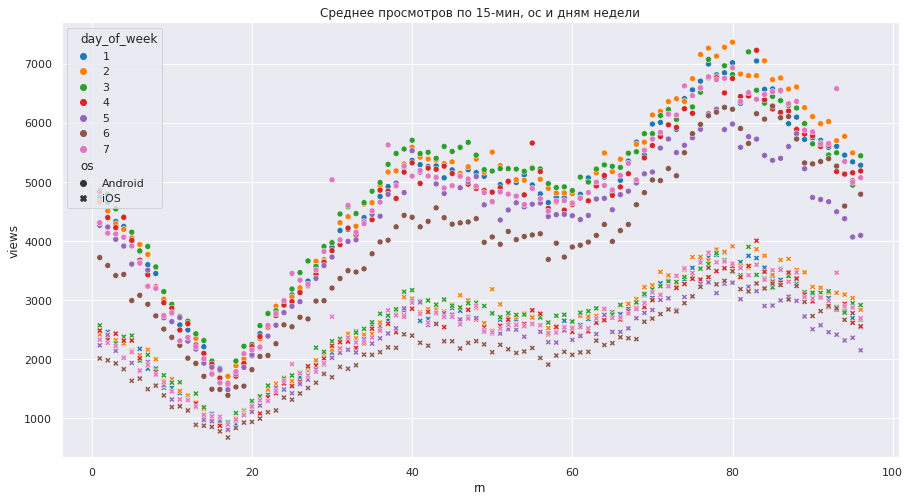

In [72]:
# среднее лайков по дням недели
views_gr = df.groupby(['day_of_week','rn','just_t', 'os'])['views'].mean().reset_index().sort_values(['day_of_week', 'rn'])
#views_gr.groupby('day_of_week')['views'].mean()
sns.scatterplot(data = views_gr, x = 'rn', y = 'views', hue = 'day_of_week', style = 'os', palette = "tab10")
plt.title('Среднее просмотров по 15-мин, ос и дням недели')

Text(0.5, 1.0, 'Среднее лайков по 15-мин, ос и дням недели')

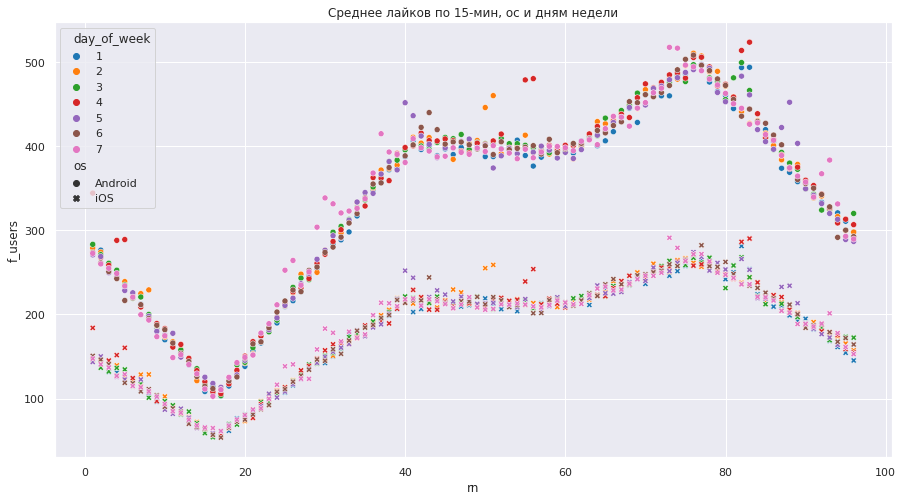

In [73]:

# среднее юзеров ленты по дням недели
f_us_gr = df.groupby(['day_of_week','rn','just_t', 'os'])['f_users'].mean().reset_index().sort_values(['day_of_week', 'rn'])
sns.scatterplot(data = f_us_gr, x = 'rn', y = 'f_users', hue = 'day_of_week', style = 'os', palette = "tab10")
plt.title('Среднее лайков по 15-мин, ос и дням недели')

Text(0.5, 1.0, 'Среднее сообщений по 15-мин, ос и дням недели')

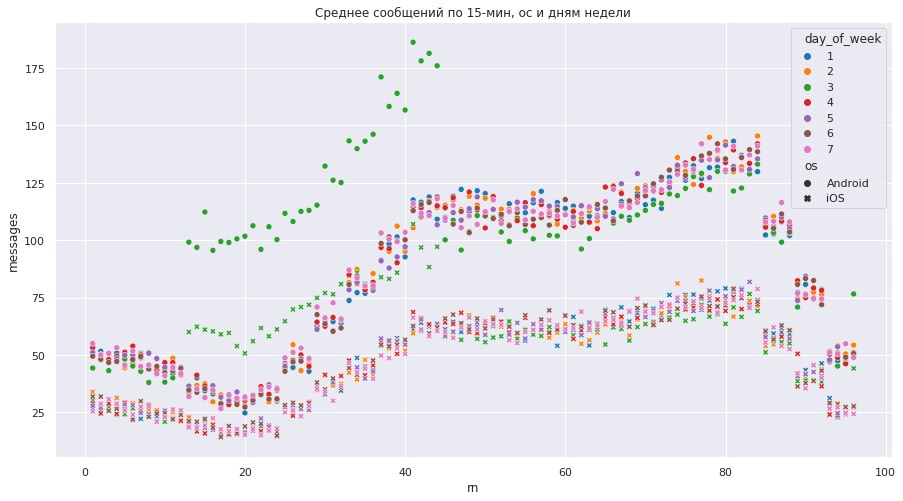

In [74]:
# среднее юзеров ленты по дням недели
f_us_gr = df.groupby(['day_of_week','rn','just_t', 'os'])['messages'].mean().reset_index().sort_values(['day_of_week', 'rn'])
sns.scatterplot(data = f_us_gr, x = 'rn', y = 'messages', hue = 'day_of_week', style = 'os', palette = "tab10")
plt.title('Среднее сообщений по 15-мин, ос и дням недели')

In [75]:
# Видим, что некая зависимость от дня недели есть.
# в суббота, скажем, просаживаются просмотры, при этом лайки, по какой-то причине, 
# во вторник(ожидаешь явную корреляцию между ними)
# Отсортируем df по 15-минтукам и os и вычислим разницу в какой-нибудь метрике для каждого дня и предшествуюшего ему дня

# пусть будет DAU в ленте
df_sorted = df.sort_values(['rn', 'os'])
df_sorted['diff_in_values'] = df_sorted['f_users'].diff(periods = 1)
#df_sorted.head()
#sns.histplot(np.array(df_sorted[df_sorted['day_of_week'] == 1]['diff_in_values']))
df_sorted.groupby(['os', 'day_of_week'])['diff_in_values'].describe()

count       mean        std    min    25%  50%   75%  \
os      day_of_week                                                         
Android 1            672.0  -6.172619  51.135395 -383.0 -17.00 -3.0  13.0   
        2            672.0   5.630952  43.581509 -478.0  -9.00  6.0  20.0   
        3            672.0  -0.169643  42.075418 -470.0 -14.25  1.0  15.0   
        4            576.0   5.774306  58.560629 -508.0 -13.00  3.0  19.0   
        5            671.0  15.931446  76.287563 -534.0 -15.00  2.0  22.5   
        6            672.0  -0.290179  42.425466 -382.0 -12.00  2.0  17.0   
        7            672.0   2.366071  48.109722 -390.0 -18.00 -2.0  13.0   
iOS     1            672.0  -3.473214  29.321983 -202.0 -13.00 -2.0  10.0   
        2            672.0   3.693452  26.597873 -238.0  -8.00  3.0  16.0   
        3            672.0  -1.093750  27.205546 -270.0 -13.00 -1.0  12.0   
        4            576.0   3.079861  33.288105 -289.0 -10.25  1.0  13.0   
        5            672.0 -24.696429  70.889390 -271.0 -22.00 -4.0  11.0   
        6            672.0  -0.625000  26.318339 -230.0 -11.00  1.0  13.0   
        7            672.0   1.163690  26.572567 -116.0 -13.00  0.0  10.0   

                       max  
os      day_of_week         
Android 1            478.0  
        2            493.0  
        3            513.0  
        4            585.0  
        5            355.0  
        6            349.0  
        7            395.0  
iOS     1            244.0  
        2            274.0  
        3            306.0  
        4            293.0  
        5            259.0  
        6            151.0  
        7            201.0

In [76]:
# Видим, что разница есть, но у каждого дня немалое СКО из-за выбросов. 
# Изначально хотелось проверять ановой, но дисперсии у нас сильно отличаются. Первый вариант - уберём самые сильные выбросы.
df_sorted = df_sorted[(df_sorted['diff_in_values'] >= df_sorted['diff_in_values'].quantile(0.05)) & \
       (df_sorted['diff_in_values'] <= df_sorted['diff_in_values'].quantile(0.95))]
list_for_anova_ios = []
list_for_anova_andr = []
for i in range(1, 8):
    values_1 = np.array(df_sorted[(df_sorted['day_of_week'] == i) & (df_sorted['os'] == 'iOS')]['diff_in_values'])
    values_1 = values_1[~np.isnan(values_1)]
    values_2 = np.array(df_sorted[(df_sorted['day_of_week'] == i) & (df_sorted['os'] == 'Android')]['diff_in_values'])
    values_2 = values_2[~np.isnan(values_2)]
    list_for_anova_ios.append(values_1)
    list_for_anova_andr.append(values_2)
                      
print('анова для андроида:', stats.f_oneway(*list_for_anova_andr))
print('анова для iOS:',stats.f_oneway(*list_for_anova_ios))

анова для андроида: F_onewayResult(statistic=10.153648294545947, pvalue=3.566228723611527e-11)
анова для iOS: F_onewayResult(statistic=6.183717026972965, pvalue=1.7935451089688069e-06)


In [77]:
# Возьмём ещё метрику для проверки


df_sorted = df.sort_values(['rn', 'os'])
df_sorted['diff_in_values'] = df_sorted['messages'].diff(periods = 1)
#df_sorted.head()
#sns.histplot(np.array(df_sorted[df_sorted['day_of_week'] == 1]['diff_in_values']))
#df_sorted.groupby(['os', 'day_of_week'])['diff_in_values'].describe()

df_sorted = df_sorted[(df_sorted['diff_in_values'] >= df_sorted['diff_in_values'].quantile(0.05)) & \
       (df_sorted['diff_in_values'] <= df_sorted['diff_in_values'].quantile(0.95))]

list_for_anova_ios = []
list_for_anova_andr = []
for i in range(1, 8):
    values_1 = np.array(df_sorted[(df_sorted['day_of_week'] == i) & (df_sorted['os'] == 'iOS')]['diff_in_values'])
    values_1 = values_1[~np.isnan(values_1)]
    values_2 = np.array(df_sorted[(df_sorted['day_of_week'] == i) & (df_sorted['os'] == 'Android')]['diff_in_values'])
    values_2 = values_2[~np.isnan(values_2)]
    list_for_anova_ios.append(values_1)
    list_for_anova_andr.append(values_2)
                      
print('анова для андроида:', stats.f_oneway(*list_for_anova_andr))
print('анова для iOS:',stats.f_oneway(*list_for_anova_ios))

анова для андроида: F_onewayResult(statistic=5.269299494341869, pvalue=2.0274716831958113e-05)
анова для iOS: F_onewayResult(statistic=3.6890567073092058, pvalue=0.001167271889065411)


In [78]:
# другой вариант - скорректированная анова для неравных дисперсий,
# его в scipy нет, так что честно заимствуем с гита
# и он дал стат. значимое ралзичие

def welch_anova_np(*args, var_equal=False):
    # link  https://github.com/scipy/scipy/issues/11122

    args = [np.asarray(arg, dtype=float) for arg in args]
    k = len(args)
    ni =np.array([len(arg) for arg in args])
    mi =np.array([np.mean(arg) for arg in args])
    vi =np.array([np.var(arg,ddof=1) for arg in args])
    wi = ni/vi

    tmp =sum((1-wi/sum(wi))**2 / (ni-1))
    tmp /= (k**2 -1)

    dfbn = k - 1
    dfwn = 1 / (3 * tmp)

    m = sum(mi*wi) / sum(wi)
    f = sum(wi * (mi - m)**2) /((dfbn) * (1 + 2 * (dfbn - 1) * tmp))
    prob = stats.f.sf(dfbn, dfwn, f) 
    return (f, prob)

print('анова для андроида:', welch_anova_np(*list_for_anova_andr))
print('анова для ios:', welch_anova_np(*list_for_anova_ios))


анова для андроида: (5.296489970328152, 0.021311596875925345)
анова для ios: (3.6867405514491094, 0.05366932790735223)


In [79]:
# А вот тут уже не всё так очевидно. Но всё же для ios p-value оказался ниже уровня значимости.
# Вывод: день недели действительно важен для расчёта разницы между значением вчера и сегодня.

In [80]:
# Посмотрим, детектирует ли iqr сильные изменения в одинаковых 15-минутках в двух соседних днях
# Детектирует, но за параметр a возьмём 2 - данных, если разбивать по дню недели, немного

In [81]:
df_sorted = df.sort_values(['rn', 'os'])
df_sorted['diff_in_values'] = df_sorted['f_users'].diff(periods = 1)
df_sorted[(df_sorted['rn'] == 90) & (df_sorted['day_of_week'] == 1) & (df_sorted['os'] == 'iOS')]['diff_in_values'].describe()

count     7.000000
mean      6.142857
std      14.299517
min     -12.000000
25%      -3.000000
50%       0.000000
75%      17.500000
max      26.000000
Name: diff_in_values, dtype: float64

<AxesSubplot:xlabel='diff_in_values', ylabel='Count'>

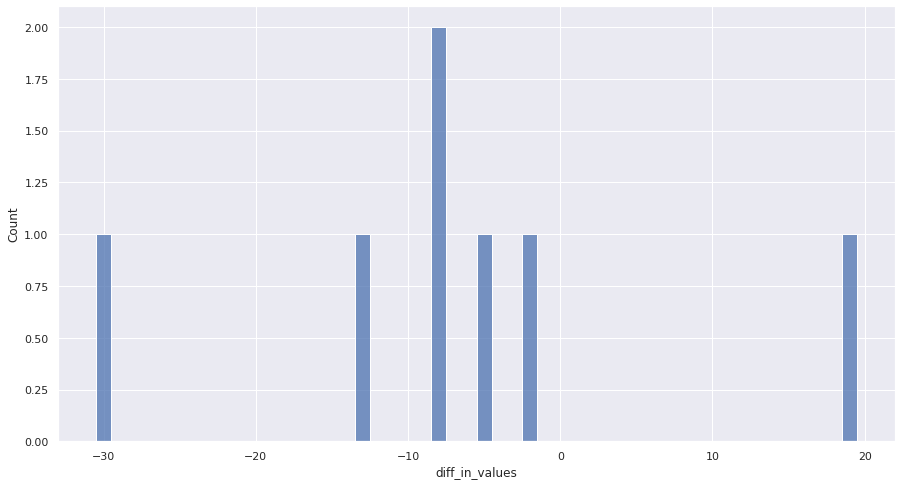

In [82]:
sns.histplot(data = df_sorted[(df_sorted['rn'] == 95) & (df_sorted['day_of_week'] == 1) & (df_sorted['os'] == 'iOS')],\
             x = 'diff_in_values', discrete = True)

In [83]:
rn = 95
metric = 'diff_in_values'
lq = df_sorted[(df_sorted['rn'] == rn) & (df_sorted['day_of_week'] == 1) & (df_sorted['os'] == 'iOS')][metric].quantile(0.25)
rq = df_sorted[(df_sorted['rn'] == rn) & (df_sorted['day_of_week'] == 1) & (df_sorted['os'] == 'iOS')][metric].quantile(0.75)
iqr = rq - lq 
a = 2
mask = (df_sorted[metric] < lq - a * iqr) | (df_sorted[metric] > rq + a * iqr)
df_sorted[(df_sorted['rn'] == rn) & (df_sorted['day_of_week'] == 1) & (df_sorted['os'] == 'iOS') & (mask)]

day_of_week          d            t_period   os  f_users  views  likes  \
765             1 2022-07-11 2022-07-11 23:30:00  iOS      153   2184    466   
3453            1 2022-07-25 2022-07-25 23:30:00  iOS      138   2544    481   

           ctr  m_users  messages  rn    just_t  dif_in_days  diff_in_values  
765   0.213370       24        29  95  23:30:00           44            19.0  
3453  0.189072       23        25  95  23:30:00           30           -30.0

К предыдущеей 15-минутке

In [84]:
# наконец, изменение по отношению к предыдущей 15-минутки

<AxesSubplot:xlabel='diff_in_values', ylabel='Count'>

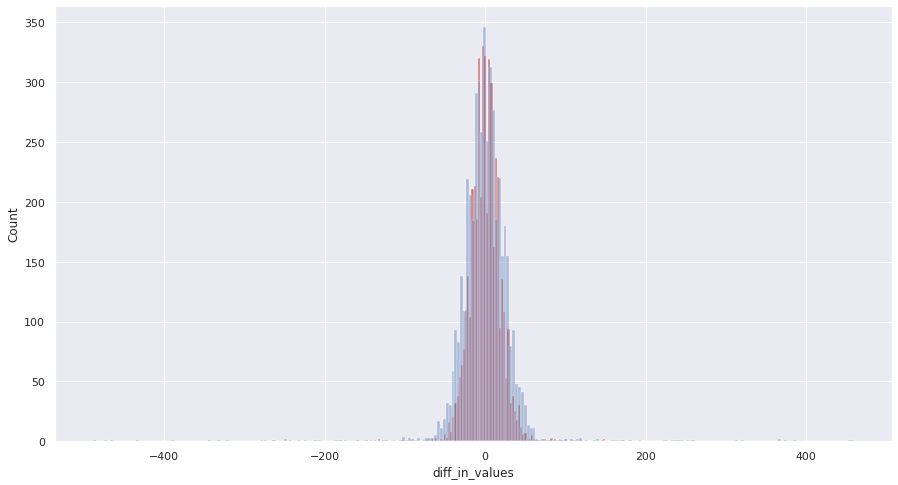

In [85]:
# разобьём по ос и будем считать разницу между двумя соседними 15-минутками

df_min_ios = df[df['os'] == 'iOS'].sort_values(['d','rn'])
df_min_ios['diff_in_values'] = df_min_ios['f_users'].diff(periods = 1)

df_min_and = df[df['os'] == 'Android'].sort_values(['d', 'rn'])
df_min_and['diff_in_values'] = df_min_and['f_users'].diff(periods = 1)

# наконец-то увидим что-то похожее на нормальное распределение
sns.histplot(data = df_min_ios, x = df_min_ios['diff_in_values'], color = 'r')
sns.histplot(data = df_min_and, x = df_min_and['diff_in_values'], alpha = 0.4)

In [86]:
# а вот тест уверен, что ненормальное. Но цифры по квартилям красивые
l = df_min_ios['diff_in_values'].quantile(0.01)
r = df_min_ios['diff_in_values'].quantile(0.99)
prob = np.array(df_min_ios[(df_min_ios['diff_in_values'] > l) & (df_min_ios['diff_in_values'] < r)]['diff_in_values'].dropna())
print(stats.shapiro(prob))
df_min_ios[(df_min_ios['diff_in_values'] > l) & (df_min_ios['diff_in_values'] < r)]['diff_in_values'].describe()

ShapiroResult(statistic=0.9978129267692566, pvalue=5.12269389219e-06)


count    4508.000000
mean        0.062334
std        16.587850
min       -44.000000
25%       -11.000000
50%         0.000000
75%        11.000000
max        47.000000
Name: diff_in_values, dtype: float64

<AxesSubplot:xlabel='diff_in_values', ylabel='Count'>

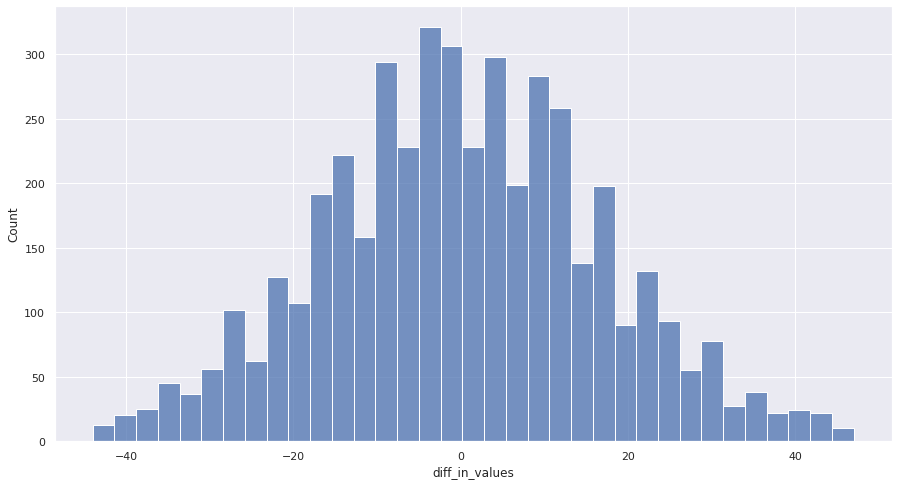

In [87]:
sns.histplot(df_min_ios[(df_min_ios['diff_in_values'] > l) & (df_min_ios['diff_in_values'] < r)]['diff_in_values'])

In [88]:
# посмтотрим на сигмы
l = df_min_ios['diff_in_values'].quantile(0.01)
r = df_min_ios['diff_in_values'].quantile(0.99)
s = df_min_ios[(df_min_ios['diff_in_values'] > l) & (df_min_ios['diff_in_values'] < r)]['diff_in_values'].std()
m = df_min_ios[(df_min_ios['diff_in_values'] > l) & (df_min_ios['diff_in_values'] < r)]['diff_in_values'].mean()
mask = (df_min_ios['diff_in_values'] <= (m - s*3)) | \
            (df_min_ios['diff_in_values'] >= (m + s*3))

# превышающие значения
# df_min_ios[mask]['diff_in_values']

In [89]:
df_month.groupby('rn')['f_users'].mean()

rn
1     212.596774
2     207.451613
3     196.387097
4     196.290323
5     188.580645
         ...    
92    258.032258
93    247.951613
94    237.758065
95    231.919355
96    225.354839
Name: f_users, Length: 96, dtype: float64

In [90]:
df['t_period'].max()

Timestamp('2022-08-24 23:45:00')

Text(0.5, 1.0, 'Среднее сообщений по 15-мин, ос и дням недели')

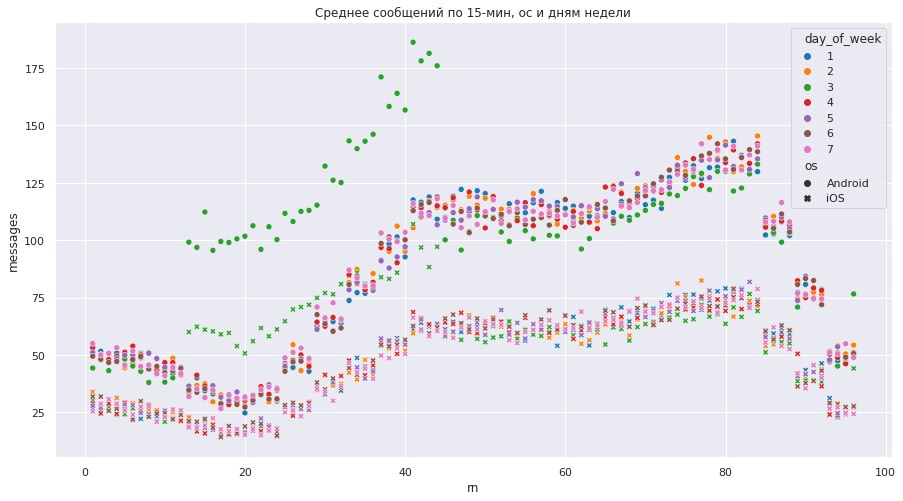

In [91]:
# среднее юзеров ленты по дням недели
f_us_gr = df.groupby(['day_of_week','rn','just_t', 'os'])['messages'].mean().reset_index().sort_values(['day_of_week', 'rn'])
sns.scatterplot(data = f_us_gr, x = 'rn', y = 'messages', hue = 'day_of_week', style = 'os', palette = "tab10")
plt.title('Среднее сообщений по 15-мин, ос и дням недели')

<AxesSubplot:xlabel='diff_in_values', ylabel='Count'>

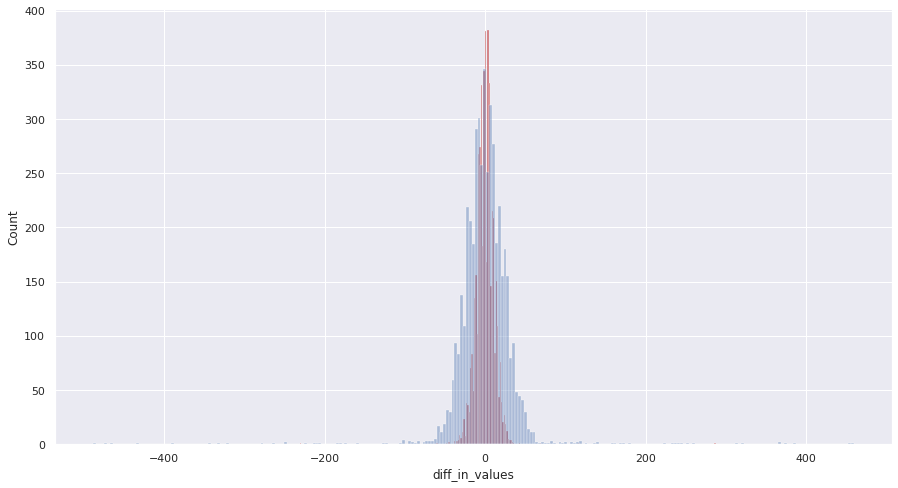

In [92]:
# разобьём по ос и будем считать разницу между двумя соседними 15-минутками

df_min_ios = df[df['os'] == 'iOS'].sort_values(['d','rn'])
df_min_ios['diff_in_values'] = df_min_ios['messages'].diff(periods = 1)

df_min_and = df[df['os'] == 'Android'].sort_values(['d', 'rn'])
df_min_and['diff_in_values'] = df_min_and['f_users'].diff(periods = 1)

# наконец-то увидим что-то похожее на нормальное распределение
sns.histplot(data = df_min_ios, x = df_min_ios['diff_in_values'], color = 'r')
sns.histplot(data = df_min_and, x = df_min_and['diff_in_values'], alpha = 0.4)

In [93]:
# посмтотрим на сигмы
l = df_min_ios['diff_in_values'].quantile(0.01)
r = df_min_ios['diff_in_values'].quantile(0.99)
s = df_min_ios[(df_min_ios['diff_in_values'] > l) & (df_min_ios['diff_in_values'] < r)]['diff_in_values'].std()
m = df_min_ios[(df_min_ios['diff_in_values'] > l) & (df_min_ios['diff_in_values'] < r)]['diff_in_values'].mean()
mask = (df_min_ios['diff_in_values'] <= (m - s*3)) | \
            (df_min_ios['diff_in_values'] >= (m + s*3))

df_min_ios[mask & (df_min_ios['day_of_week'] == 3)]

day_of_week          d            t_period   os  f_users  views  likes  \
2329            3 2022-07-20 2022-07-20 03:00:00  iOS       89   1287    280   
2341            3 2022-07-20 2022-07-20 04:30:00  iOS       62    791    176   
2351            3 2022-07-20 2022-07-20 05:45:00  iOS       91   1343    323   
2361            3 2022-07-20 2022-07-20 07:00:00  iOS      126   1562    384   
2373            3 2022-07-20 2022-07-20 08:30:00  iOS      202   2596    567   
2383            3 2022-07-20 2022-07-20 09:45:00  iOS      224   2712    584   
2389            3 2022-07-20 2022-07-20 10:30:00  iOS      190   2226    491   
2393            3 2022-07-20 2022-07-20 11:00:00  iOS      213   2368    508   
3739            3 2022-07-27 2022-07-27 11:15:00  iOS      209   2819    592   
7849            3 2022-08-17 2022-08-17 21:00:00  iOS      209   3750    809   
9215            3 2022-08-24 2022-08-24 23:45:00  iOS      128   2587    553   

           ctr  m_users  messages  rn    just_t  dif_in_days  diff_in_values  
2329  0.217560       92       299  13  03:00:00           35           287.0  
2341  0.222503      145       266  19  04:30:00           35           -45.0  
2351  0.240506      175       332  24  05:45:00           35            34.0  
2361  0.245839      156       303  29  07:00:00           35           -39.0  
2373  0.218413       98       293  35  08:30:00           35           -33.0  
2383  0.215339      137       337  40  09:45:00           35            69.0  
2389  0.220575       85       275  43  10:30:00           35           -60.0  
2393  0.214527       30        38  45  11:00:00           35          -231.0  
3739  0.210004       54        81  46  11:15:00           28            34.0  
7849  0.215733       43        55  85  21:00:00            7           -31.0  
9215  0.213761       90       147  96  23:45:00            0           117.0

In [94]:
df_min_ios[df_min_ios['d'] == '2022-07-20'][:30]

day_of_week          d            t_period   os  f_users  views  likes  \
2305            3 2022-07-20 2022-07-20 00:00:00  iOS      146   2299    480   
2307            3 2022-07-20 2022-07-20 00:15:00  iOS      139   2101    469   
2309            3 2022-07-20 2022-07-20 00:30:00  iOS      128   1832    422   
2311            3 2022-07-20 2022-07-20 00:45:00  iOS      129   2077    484   
2313            3 2022-07-20 2022-07-20 01:00:00  iOS      131   1967    474   
2315            3 2022-07-20 2022-07-20 01:15:00  iOS      114   1694    419   
2317            3 2022-07-20 2022-07-20 01:30:00  iOS      135   2161    475   
2319            3 2022-07-20 2022-07-20 01:45:00  iOS      101   1582    377   
2321            3 2022-07-20 2022-07-20 02:00:00  iOS      107   1489    341   
2323            3 2022-07-20 2022-07-20 02:15:00  iOS       81   1151    304   
2325            3 2022-07-20 2022-07-20 02:30:00  iOS       97   1437    359   
2327            3 2022-07-20 2022-07-20 02:45:00  iOS       81   1192    287   
2329            3 2022-07-20 2022-07-20 03:00:00  iOS       89   1287    280   
2331            3 2022-07-20 2022-07-20 03:15:00  iOS       80   1148    261   
2333            3 2022-07-20 2022-07-20 03:30:00  iOS       63    956    211   
2335            3 2022-07-20 2022-07-20 03:45:00  iOS       63    962    219   
2337            3 2022-07-20 2022-07-20 04:00:00  iOS       68    946    228   
2339            3 2022-07-20 2022-07-20 04:15:00  iOS       65    929    218   
2341            3 2022-07-20 2022-07-20 04:30:00  iOS       62    791    176   
2343            3 2022-07-20 2022-07-20 04:45:00  iOS       89   1254    302   
2345            3 2022-07-20 2022-07-20 05:00:00  iOS       90   1265    286   
2347            3 2022-07-20 2022-07-20 05:15:00  iOS       94   1349    304   
2349            3 2022-07-20 2022-07-20 05:30:00  iOS       98   1291    276   
2351            3 2022-07-20 2022-07-20 05:45:00  iOS       91   1343    323   
2353            3 2022-07-20 2022-07-20 06:00:00  iOS      126   1630    360   
2355            3 2022-07-20 2022-07-20 06:15:00  iOS      139   1758    398   
2357            3 2022-07-20 2022-07-20 06:30:00  iOS      146   1925    444   
2359            3 2022-07-20 2022-07-20 06:45:00  iOS      129   1769    403   
2361            3 2022-07-20 2022-07-20 07:00:00  iOS      126   1562    384   
2363            3 2022-07-20 2022-07-20 07:15:00  iOS      151   1979    460   

           ctr  m_users  messages  rn    just_t  dif_in_days  diff_in_values  
2305  0.208786       11        11   1  00:00:00           35            -9.0  
2307  0.223227       11        13   2  00:15:00           35             2.0  
2309  0.230349       16        17   3  00:30:00           35             4.0  
2311  0.233028       13        13   4  00:45:00           35            -4.0  
2313  0.240976       10        10   5  01:00:00           35            -3.0  
2315  0.247344       12        12   6  01:15:00           35             2.0  
2317  0.219806       21        26   7  01:30:00           35            14.0  
2319  0.238306       10        11   8  01:45:00           35           -15.0  
2321  0.229013       12        13   9  02:00:00           35             2.0  
2323  0.264118       12        15  10  02:15:00           35             2.0  
2325  0.249826       16        18  11  02:30:00           35             3.0  
2327  0.240772       12        12  12  02:45:00           35            -6.0  
2329  0.217560       92       299  13  03:00:00           35           287.0  
2331  0.227352      149       294  14  03:15:00           35            -5.0  
2333  0.220711       94       308  15  03:30:00           35            14.0  
2335  0.227651      156       301  16  03:45:00           35            -7.0  
2337  0.241015      101       292  17  04:00:00           35            -9.0  
2339  0.234661      104       311  18  04:15:00           35            19.0  
2341  0.222503      145 